In [3]:
import xarray as xr # requires >= 0.15.1
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.getcwd()

%cd /g/data/p66/ars599/work_eae

/g/data/p66/ars599/work_eae


In [4]:
'''
dealing with 1/4 ocean data and apply EOF on IO and PO

'''

y1_hist = 2000
y2_hist = 2009

idir = './'
r1Name = 'thetao_Omon_ACCESS-CM2_historical_r71p1f1_gn_200001-200912_v10.anom.nc'
fname = idir + r1Name
thetao_in_hist = xr.open_mfdataset(fname, combine='by_coords').thetao.load()

tm_hist = thetao_in_hist.time
tm_hist_ind = (tm_hist.dt.year>=y1_hist)&(tm_hist.dt.year<=y2_hist)
thetao_hist = thetao_in_hist[tm_hist_ind,:,:,:] # 0 m to 50 meter
thetao_hist = thetao_hist.rename({"latitude":"lat","longitude":"lon"})

tos_hist = thetao_in_hist[tm_hist_ind,0,:,:] # 0 m to 50 meter
tos_hist = tos_hist.rename({"latitude":"lat","longitude":"lon"})


In [5]:
# function for quadratic detrending
def xarray_quadratic_detrend_tll(data):
    # detrends a three-dimensional
    # (time,lat,lon)
    # xarray dataarray separately at
    # each grid point
    # easy to do, but slow, with a loop-
    # so this is a vectorized
    # way of doing it
    # https://stackoverflow.com/questions/38960903/applying-numpy-polyfit-to-xarray-dataset

    def quadratic_trend_coef(x,y):
        pf = np.polyfit(x, y, 2)
        return xr.DataArray(pf[0])
    def linear_trend_coef(x, y):
        pf = np.polyfit(x, y, 2)
        return xr.DataArray(pf[1])
    def intercepts(x, y):
        pf = np.polyfit(x, y, 2)
        return xr.DataArray(pf[2])

    tm = data.time
    lt = data.lat
    ln = data.lon
    timevals = xr.DataArray(np.arange(1,len(tm)+1,1),
                        coords=[tm],
                        dims=["time"])
    timevals = timevals.expand_dims(lat=lt,lon=ln)
    timevals = timevals.transpose("time","lat","lon")

    quad_coef = xr.apply_ufunc(quadratic_trend_coef,
                            timevals,data,
                            vectorize=True,
                            input_core_dims=[["time"],["time"]])
    lin_coef = xr.apply_ufunc(linear_trend_coef,
                            timevals,data,
                            vectorize=True,
                            input_core_dims=[["time"],["time"]])
    int_coef = xr.apply_ufunc(intercepts,
                            timevals,data,
                            vectorize=True,
                            input_core_dims=[["time"],["time"]])

    predicted_vals = (int_coef + lin_coef*(timevals) + quad_coef*(timevals**2)).transpose("time","lat","lon")
    detrended_data = data - predicted_vals
    return detrended_data

# Functions for ENSO calculations

def calc_sst_anom_region(sst,y1,y2,latmin,latmax,lonmin,lonmax):
    # don't need year indices since we're just doing it over the entire period
    # assumes time x lat x lon
    time_ind = (sst.time.dt.year>=y1) & (sst.time.dt.year<=y2)
    sst_clm = sst[time_ind,:,:].groupby("time.month").mean(dim="time")
    sst_anom = sst.groupby("time.month") - sst_clm
    sst_anom_region = sst_anom.loc[:,latmin:latmax,lonmin:lonmax]
    return(sst_anom_region)

In [6]:
# now create entirely new variable with one-dimensional coordinates
lat = tos_hist.lat.values[:,0]
lon = (tos_hist.lon.values[0,:])
lev = thetao_hist.lev

temp_hist = xr.DataArray(thetao_hist.values,
                    coords=[thetao_hist.time,lev,lat,lon],
                    dims=["time","lev","lat","lon"])
pot_temp = xr.concat([temp_hist],dim="time")

sst_hist = xr.DataArray(tos_hist.values,
                    coords=[tos_hist.time,lat,lon],
                    dims=["time","lat","lon"])
sst = xr.concat([sst_hist],dim="time")
#del([temp_hist])
#del([sst_hist])

if pot_temp.max()>200:
    pot_temp = sst - 273.15

if sst.max()>200:
    sst = sst - 273.15

In [14]:
'''
Pacific thetao and tos
'''
# convert SST to 360 degree longitude
pot_temp.coords["lon"] = lon % 360
sst.coords["lon"] = lon % 360

y1_hist,y2_hist,lat_min,lat_max,lon_min,lon_max = [2000,2009,-20,20,140,280]
thetao_t = pot_temp.where((pot_temp.lon > lon_min) & (pot_temp.lon < lon_max) & (pot_temp.lat > lat_min) & (pot_temp.lat < lat_max), drop=True)

y1_hist,y2_hist,lat_min,lat_max,lon_min,lon_max = [2000,2009,-5,5,190,240]
sst_t = sst.where((sst.lon > lon_min) & (sst.lon < lon_max) & (sst.lat > lat_min) & (sst.lat < lat_max), drop=True)

# if the anomaly wasn't prepared then remark the following
#time = sst_t.time
#sst_anom_region = calc_sst_anom_region(sst_t,y1_hist,y2_hist,lat_min,lat_max,lon_min,lon_max)
#sst_anom_region.std(dim='time').plot()
#sst_anom_region = sst_anom_region.drop("month") # better keep in here rather than next session


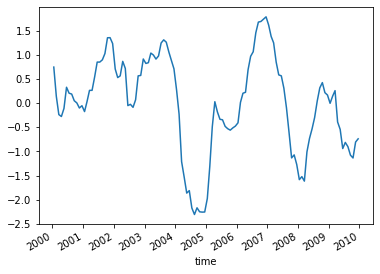

In [15]:
'''
plot Nino3.4 index
'''
sst_t.mean(['lat','lon']).plot()

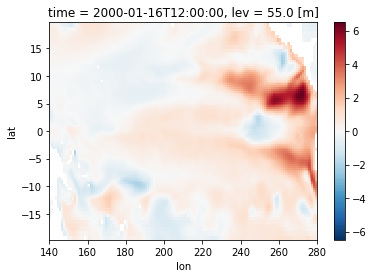

In [23]:
'''
plot the contour over the Pacific Region
at 55 meter
'''
lev = thetao_t.lev
thetao_t[0].sel(lev=55).plot()